## Antecedentes

| Model         | Best Hyperparameters                                                                                                                                         | Best Score (AUCROC)   |
|---------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------|-----------------------|
| Decision Tree | {'splitter': 'best', 'random_state': 42, 'min_samples_leaf': 19, 'max_features': 200, 'max_depth': 9, 'criterion': 'entropy', 'class_weight': {0: 1, 1: 2}} | 0.6899568090876336    |
| KNN           | {'weights': 'distance', 'p': 1, 'n_neighbors': 17, 'metric': 'manhattan', 'leaf_size': 47, 'algorithm': 'auto'}                                             | 0.8832015323054749    |
| SVM           | {'random_state': 42, 'probability': True, 'kernel': 'rbf', 'gamma': np.float64(0.00012030053494233243), 'degree': 3, 'C': np.float64(6.622565812684657)}     | 0.9257305949062221    |
| LDA           | Default                                                                                                                                                     | 0.7474749198763535    |
| GaussianNB    | Default                                                                                                                                                     | 0.7714243044888207    |
| BernoulliNB   | Default                                                                                                                                                     | 0.7187778536344844    |
| Dummy         | Default                                                                                                                                                     | 0.5                   |


In [1]:
import pandas as pd

datos = pd.read_csv('../datos/data.csv')
datos.describe()

,QqgU,IJsJ,YlJA,tFLR,MYkJ,Cado,cmdU,AUYy,mVEY,zSZq,...,cgNV,naPw,EOre,sMSU,TihR,sbWq,aWBQ,fGxK,JWOq,target
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,...,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.596881,0.017897,0.061780,0.015749,-0.042228,-0.019042,-0.001894,0.003554,0.691093,0.063590,...,0.025222,0.007754,0.074033,-0.021483,0.999983,-0.294412,0.075788,-0.045586,-0.029516,0.302000
std,3.708092,0.962171,0.976632,0.972275,1.056334,0.963882,0.923628,0.948914,11.957359,0.992934,...,1.012634,1.045955,1.015063,1.039655,3.533861,3.755950,0.979493,0.990029,0.974942,0.459585
min,-9.157346,-2.550701,-2.798342,-2.566473,-2.857898,-2.797807,-2.597936,-2.809267,-49.340125,-2.884792,...,-3.888132,-2.766294,-3.699257,-2.909058,-8.667690,-8.796835,-2.782769,-3.082403,-3.237248,0.000000
25%,-1.881289,-0.585681,-0.660611,-0.641315,-0.789625,-0.708364,-0.643213,-0.656062,-7.899738,-0.580958,...,-0.644617,-0.652799,-0.573796,-0.746705,-1.388182,-2.825256,-0.581086,-0.700993,-0.621571,0.000000
50%,0.241144,0.041817,0.056013,0.026078,-0.033431,-0.012760,-0.033506,0.008271,0.676209,0.019028,...,0.043849,0.029907,0.058734,0.012076,1.011895,-0.331294,0.058389,-0.017068,-0.031891,0.000000
75%,2.929641,0.711183,0.767197,0.628204,0.742411,0.631819,0.652040,0.624847,8.698999,0.732256,...,0.703999,0.710110,0.750579,0.676974,3.321077,2.094815,0.758615,0.616583,0.648717,1.000000
max,14.654553,2.460345,3.176496,3.132863,3.326253,2.656422,2.701276,4.010676,33.346217,2.855117,...,2.837511,2.964380,2.904136,2.704834,12.214838,9.923424,2.753496,3.165953,3.147763,1.000000


In [2]:
#Separacion original previa
def our_train_test_split(data):
    target_ones = data[data["target"]==1]
    target_zeros = data[data["target"]==0]
    target_ones_train_split = target_ones.sample(frac=0.9, random_state=1)
    target_ones_test_split = target_ones.drop(target_ones_train_split.index)
    target_zeros_train_split = target_zeros.sample(frac=0.9, random_state=1)
    target_zeros_test_split = target_zeros.drop(target_zeros_train_split.index)
    train = pd.concat([target_ones_train_split, target_zeros_train_split]).sample(frac=1, random_state=1)
    test = pd.concat([target_ones_test_split, target_zeros_test_split]).sample(frac=1, random_state=1)
    return train.iloc[:,0:200], test.iloc[:,0:200], train.target, test.target

x_desarrollo, x_evaluacion, y_desarrollo, y_evaluacion = our_train_test_split(datos)


In [6]:
import torch
import torch.nn as nn
print(torch.__version__)
print(torch.cuda.is_available())

2.7.0+cu118
True


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Datos

In [35]:
from torch.utils.data import DataLoader, random_split, Dataset
import numpy as np
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __getitem__(self, index):
        row = self.dataframe.iloc[index].to_numpy(dtype=np.float32)
        features = row[:-1]
        label = row[-1]
        return features, label

    def __len__(self):
        return len(self.dataframe)
    
full_dataset = pd.concat([x_desarrollo, y_desarrollo], axis=1)

full_dataset = CustomDataset(full_dataset)

In [37]:
total_size = len(full_dataset)
train_size = int(0.8 * total_size)
test_size = total_size - train_size

# Separar el dataset
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Crear dataloaders
batch_size = 8

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size
)

## Regresion logistica

In [38]:
class logisticRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(200), requires_grad=True)

        self.bias = nn.Parameter(torch.randn(1), requires_grad=True)

    # Forward define la pasada forward en el modelo
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.sigmoid(torch.matmul(x, self.weights) + self.bias)

In [80]:
# Establecer semilla manual ya que nn.Parameter se inicializa aleatoriamente
torch.manual_seed(42)

# Crear una instancia del modelo (esto es una subclase de nn.Module que contiene nn.Parameter(s))
model_0 = logisticRegressionModel()

# Revisar los nn.Parameter(s) dentro de la subclase nn.Module que creamos
list(model_0.parameters())

[Parameter containing:
 tensor([ 1.9269e+00,  1.4873e+00,  9.0072e-01, -2.1055e+00,  6.7842e-01,
         -1.2345e+00, -4.3067e-02, -1.6047e+00, -7.5214e-01,  1.6487e+00,
         -3.9248e-01, -1.4036e+00, -7.2788e-01, -5.5943e-01, -7.6884e-01,
          7.6245e-01,  1.6423e+00, -1.5960e-01, -4.9740e-01,  4.3959e-01,
         -7.5813e-01,  1.0783e+00,  8.0080e-01,  1.6806e+00,  1.2791e+00,
          1.2964e+00,  6.1047e-01,  1.3347e+00, -2.3162e-01,  4.1759e-02,
         -2.5158e-01,  8.5986e-01, -1.3847e+00, -8.7124e-01, -2.2337e-01,
          1.7174e+00,  3.1888e-01, -4.2452e-01,  3.0572e-01, -7.7459e-01,
         -1.5576e+00,  9.9564e-01, -8.7979e-01, -6.0114e-01, -1.2742e+00,
          2.1228e+00, -1.2347e+00, -4.8791e-01, -9.1382e-01, -6.5814e-01,
          7.8024e-02,  5.2581e-01, -4.8799e-01,  1.1914e+00, -8.1401e-01,
         -7.3599e-01, -1.4032e+00,  3.6004e-02, -6.3477e-02,  6.7561e-01,
         -9.7807e-02,  1.8446e+00, -1.1845e+00,  1.3835e+00,  1.4451e+00,
          8.564

In [81]:
model_0.state_dict()

OrderedDict([('weights',
              tensor([ 1.9269e+00,  1.4873e+00,  9.0072e-01, -2.1055e+00,  6.7842e-01,
                      -1.2345e+00, -4.3067e-02, -1.6047e+00, -7.5214e-01,  1.6487e+00,
                      -3.9248e-01, -1.4036e+00, -7.2788e-01, -5.5943e-01, -7.6884e-01,
                       7.6245e-01,  1.6423e+00, -1.5960e-01, -4.9740e-01,  4.3959e-01,
                      -7.5813e-01,  1.0783e+00,  8.0080e-01,  1.6806e+00,  1.2791e+00,
                       1.2964e+00,  6.1047e-01,  1.3347e+00, -2.3162e-01,  4.1759e-02,
                      -2.5158e-01,  8.5986e-01, -1.3847e+00, -8.7124e-01, -2.2337e-01,
                       1.7174e+00,  3.1888e-01, -4.2452e-01,  3.0572e-01, -7.7459e-01,
                      -1.5576e+00,  9.9564e-01, -8.7979e-01, -6.0114e-01, -1.2742e+00,
                       2.1228e+00, -1.2347e+00, -4.8791e-01, -9.1382e-01, -6.5814e-01,
                       7.8024e-02,  5.2581e-01, -4.8799e-01,  1.1914e+00, -8.1401e-01,
                  

In [82]:
predictions = []
with torch.inference_mode():  # o torch.no_grad()
    for X_batch, y_batch in test_loader:
        batch_preds = model_0(X_batch)
        predictions.append(batch_preds)

    y_preds = torch.cat(predictions)

print(y_preds)

tensor([3.6264e-15, 9.9994e-01, 1.0000e+00, 9.9962e-01, 1.1439e-02, 1.3391e-09,
        2.2629e-03, 1.4102e-18, 8.5986e-07, 1.0000e+00, 9.9866e-01, 4.1919e-25,
        1.0000e+00, 9.8394e-20, 9.8322e-01, 1.0000e+00, 9.9993e-01, 3.5891e-20,
        5.5406e-09, 4.2562e-05, 3.5076e-11, 4.1671e-31, 1.0000e+00, 1.0000e+00,
        5.0295e-26, 8.7547e-01, 1.9270e-18, 2.9571e-14, 2.9035e-13, 1.0000e+00,
        1.0000e+00, 8.2756e-01, 9.9993e-01, 5.4472e-15, 1.2449e-24, 1.0000e+00,
        3.7570e-38, 5.5820e-18, 1.0000e+00, 4.2905e-10, 1.0000e+00, 1.3364e-11,
        0.0000e+00, 6.9941e-21, 1.0000e+00, 1.8032e-13, 1.5734e-03, 1.0000e+00,
        1.0982e-13, 1.8568e-26, 4.0171e-31, 2.7816e-08, 3.3540e-16, 1.0000e+00,
        9.7192e-01, 8.0334e-24, 1.0000e+00, 6.7070e-25, 2.4581e-21, 6.8602e-22,
        6.1604e-28, 1.0000e+00, 0.0000e+00, 4.4286e-14, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 6.0799e-01, 4.1568e-01,
        1.0000e+00, 3.6013e-11, 4.4223e-

In [83]:
# Chequear predicciones
print(f"Número de muestras de prueba: {test_size}")
print(f"Número de predicciones realizadas: {len(y_preds)}")

Número de muestras de prueba: 90
Número de predicciones realizadas: 90


In [84]:
y_test = torch.cat([batch[1] for batch in test_loader])
y_test - y_preds

tensor([ 1.0000e+00,  5.5194e-05,  0.0000e+00, -9.9962e-01, -1.1439e-02,
        -1.3391e-09, -2.2629e-03, -1.4102e-18, -8.5986e-07, -1.0000e+00,
        -9.9866e-01,  1.0000e+00, -1.0000e+00,  1.0000e+00, -9.8322e-01,
        -1.0000e+00,  7.4744e-05,  1.0000e+00, -5.5406e-09,  9.9996e-01,
        -3.5076e-11, -4.1671e-31, -1.0000e+00,  0.0000e+00, -5.0295e-26,
        -8.7547e-01, -1.9270e-18,  1.0000e+00, -2.9035e-13, -1.0000e+00,
        -1.0000e+00, -8.2756e-01,  6.6042e-05, -5.4472e-15, -1.2449e-24,
         0.0000e+00,  1.0000e+00, -5.5820e-18,  0.0000e+00, -4.2905e-10,
        -1.0000e+00, -1.3364e-11,  1.0000e+00, -6.9941e-21, -1.0000e+00,
        -1.8032e-13,  9.9843e-01, -1.0000e+00,  1.0000e+00, -1.8568e-26,
         1.0000e+00,  1.0000e+00, -3.3540e-16,  0.0000e+00, -9.7192e-01,
        -8.0334e-24, -1.0000e+00, -6.7070e-25, -2.4581e-21,  1.0000e+00,
        -6.1604e-28, -1.0000e+00,  0.0000e+00,  1.0000e+00, -1.0000e+00,
        -1.0000e+00,  0.0000e+00, -1.0000e+00,  0.0

In [85]:
loss_fn = nn.BCELoss()

optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)

In [86]:
torch.manual_seed(42)

epochs = 400

# Empty lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    ### Training
    model_0.train()
    train_loss = 0

    # Loop through training batches
    for X_batch, y_batch in train_loader:
        # 1. Forward pass
        y_pred = model_0(X_batch)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y_batch)

        # 3. Zero gradients
        optimizer.zero_grad()

        # 4. Backpropagation
        loss.backward()

        # 5. Update parameters
        optimizer.step()

        # Accumulate batch loss
        train_loss += loss.item()

    # Calculate average training loss for the epoch
    train_loss = train_loss / len(train_loader)

    ### Testing
    model_0.eval()
    test_loss = 0

    with torch.inference_mode():
        # Loop through test batches
        for X_batch, y_batch in test_loader:
            # 1. Forward pass on test data
            test_pred = model_0(X_batch)

            # 2. Calculate test loss
            batch_test_loss = loss_fn(test_pred, y_batch)

            # Accumulate batch test loss
            test_loss += batch_test_loss.item()

        # Calculate average test loss for the epoch
        test_loss = test_loss / len(test_loader)

    # Print progress every 10 epochs
    if epoch % 10 == 0:
        epoch_count.append(epoch)
        train_loss_values.append(train_loss)
        test_loss_values.append(test_loss)
        print(f"Epoch: {epoch} | Train Loss: {train_loss:.5f} | Test Loss: {test_loss:.5f}")



Epoch: 0 | Train Loss: 19.01592 | Test Loss: 18.19705
Epoch: 10 | Train Loss: 14.95823 | Test Loss: 18.50362
Epoch: 20 | Train Loss: 14.35346 | Test Loss: 17.20980
Epoch: 30 | Train Loss: 13.65769 | Test Loss: 15.91685
Epoch: 40 | Train Loss: 12.60384 | Test Loss: 13.75915
Epoch: 50 | Train Loss: 12.34496 | Test Loss: 13.68631
Epoch: 60 | Train Loss: 12.19823 | Test Loss: 15.42550
Epoch: 70 | Train Loss: 12.15305 | Test Loss: 13.56112
Epoch: 80 | Train Loss: 12.11288 | Test Loss: 15.31430
Epoch: 90 | Train Loss: 11.83467 | Test Loss: 13.34086
Epoch: 100 | Train Loss: 11.45684 | Test Loss: 12.17379
Epoch: 110 | Train Loss: 11.16282 | Test Loss: 12.34325
Epoch: 120 | Train Loss: 10.37353 | Test Loss: 12.24453
Epoch: 130 | Train Loss: 9.79833 | Test Loss: 11.30234
Epoch: 140 | Train Loss: 8.67533 | Test Loss: 13.45862
Epoch: 150 | Train Loss: 8.00410 | Test Loss: 11.23507
Epoch: 160 | Train Loss: 7.60291 | Test Loss: 10.97403
Epoch: 170 | Train Loss: 7.26333 | Test Loss: 10.88826
Epoch: 1

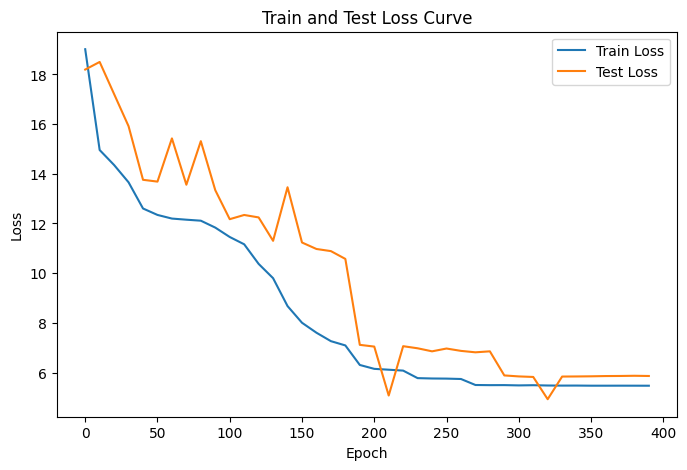

In [87]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(epoch_count, train_loss_values, label='Train Loss')
plt.plot(epoch_count, test_loss_values, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss Curve')
plt.legend()
plt.show()

In [88]:
print("\nParámetros del modelo:")
print(model_0.state_dict())


Parámetros del modelo:
OrderedDict({'weights': tensor([ 0.9159, -0.4962,  0.2307, -0.9817,  0.3765, -0.1504,  0.4228, -1.3395,
        -0.0435,  1.0613,  0.4702,  0.1876, -0.4466, -1.1991, -2.1773, -0.3149,
         0.5750,  0.3959, -0.6647,  0.9047, -1.1406,  0.5833,  0.4156,  1.1810,
         1.5195,  1.4003, -0.2471,  1.2618, -1.1349,  1.1246, -0.0573,  1.5650,
        -1.2917, -0.9966, -0.3822,  1.7782,  0.0631, -0.0902,  1.0494,  0.1761,
        -1.2447,  1.9287,  1.1060, -0.4434, -0.6009,  2.2854, -0.6516, -0.6226,
        -1.0017, -0.8160, -0.9423,  0.7928, -1.3674,  0.8113, -0.4846, -1.9039,
         0.9332, -0.6643, -0.6481, -0.4712, -0.6780,  1.4598, -0.7749,  1.9347,
         2.0197, -0.7502,  1.7172,  0.5903,  1.8368, -0.6419, -0.3001,  0.9946,
        -0.7468,  0.5415,  0.9686, -0.3354,  1.1279, -0.4256, -1.8111, -0.2971,
        -0.6608,  0.0267, -0.5848, -1.6415,  1.0031,  0.9086,  0.7286,  0.7840,
        -0.4432,  0.1018,  0.9858,  0.5852, -0.9939, -0.2731,  0.9323,  

In [89]:
predictions = []
with torch.inference_mode():  # o torch.no_grad()
    for X_batch, y_batch in test_loader:
        batch_preds = model_0(X_batch)
        predictions.append(batch_preds)

    y_preds = torch.cat(predictions)

print(y_preds)

tensor([1.0546e-08, 1.0000e+00, 1.0000e+00, 2.4707e-13, 1.0340e-20, 5.7854e-11,
        1.8086e-29, 1.2858e-17, 6.4687e-07, 1.0000e+00, 1.5522e-07, 3.5644e-09,
        8.7642e-15, 1.0000e+00, 1.0448e-23, 8.0845e-01, 1.0000e+00, 9.9999e-01,
        2.7452e-18, 1.0000e+00, 7.6520e-03, 1.2993e-29, 9.8995e-01, 9.9560e-01,
        4.6615e-01, 2.7325e-22, 1.7921e-24, 1.0000e+00, 7.4900e-22, 6.9851e-13,
        1.0000e+00, 1.5948e-02, 1.0000e+00, 9.0449e-01, 5.2463e-04, 1.0000e+00,
        1.4749e-14, 1.0000e+00, 9.9998e-01, 3.2902e-04, 2.0833e-12, 2.5851e-08,
        9.9958e-01, 7.4395e-01, 1.0000e+00, 1.4571e-20, 1.0000e+00, 1.5961e-03,
        1.0000e+00, 0.0000e+00, 2.2295e-08, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        7.2483e-24, 8.0969e-10, 9.9997e-01, 2.0294e-02, 6.0696e-03, 1.0000e+00,
        2.0517e-21, 3.4926e-11, 6.7281e-01, 3.1623e-17, 1.0194e-04, 9.9993e-01,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 3.5425e-20, 1.0000e+00, 1.0309e-01,
        9.9935e-01, 9.7764e-01, 5.3051e-

In [90]:
y_test = torch.cat([batch[1] for batch in test_loader])
sum(abs(y_test - y_preds)) / len(y_test)

tensor(0.2321)

In [91]:
from sklearn.metrics import roc_auc_score

auc_roc = roc_auc_score(y_test, y_preds)
print(f"AUC ROC: {auc_roc}")

AUC ROC: 0.8311111111111111


In [92]:
# 1. Establecer el modelo en modo evaluación
model_0.eval()

# 2. Calcular predicciones
with torch.inference_mode():
    predictions = []
    true_values = []

    for X_batch, y_batch in test_loader:
        # Opcional: Mover los datos al dispositivo necesario
        # X_batch = X_batch.to(device)
        # y_batch = y_batch.to(device)

        # Inferencia
        batch_preds = model_0(X_batch)

        # Guardar predicciones y real
        predictions.append(batch_preds)
        true_values.append(y_batch)

    # Combinar las predicciones de todos los batches
    y_preds = torch.cat(predictions)
    y_test = torch.cat(true_values)